In [7]:
import pandas as pd
# import torchio as tio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os

In [70]:
img = np.load('/workspaces/data/MegaGen/testNpy/BraTS-MEN-RT-0200-1_slice_088_img.npy', allow_pickle=True)
img2 = np.load('/workspaces/data/brain_meningioma/slice_old/slice_train_f/npy/BraTS-MEN-RT-0202-1_z130_img.npy', allow_pickle=True)

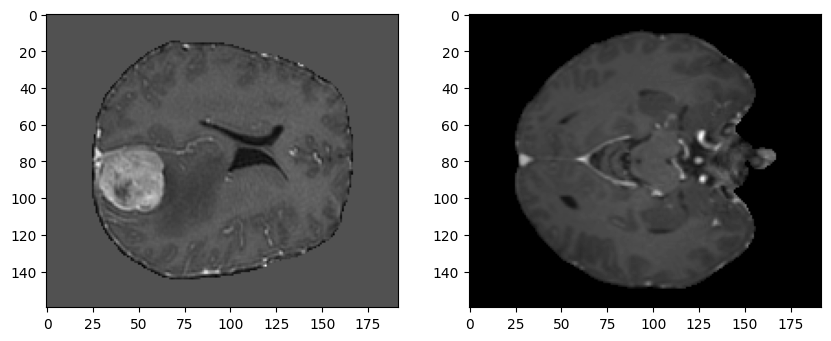

In [71]:
fig, axes = plt.subplots(1,2,figsize=(10, 5))
# img, mask = train_data0[0], train_data0[2]
axes[0].imshow(img, cmap='gray')
axes[1].imshow(img2, cmap='gray')

In [80]:
import sys
sys.path.append('/workspaces/project/MegaGen')
from utils.data_utils import get_loader
from types import SimpleNamespace
args = SimpleNamespace()
args.data_dir = '/workspaces/data/brain_meningioma/slice'
args.json_list = "/workspaces/data/MegaGen/inputs/dataset_split_brats2.json"
args.fold = 0
args.spatial_dims = 2
args.roi_x = 160
args.roi_y = 192
args.test_mode = False
args.out_base = 'unet1-bras2'
args.distributed = False
args.batch_size = 8
args.workers = 8
args.nbatch_val = 1

In [73]:
loader = get_loader(args)

In [74]:
import numpy as np
img0 = np.load(loader[0].dataset.data[0]['image'])
print (img0.shape)

(160, 192)


In [77]:
loader[0].dataset.data

[{'image': '/workspaces/data/brain_meningioma/slice/s_train/npy/BraTS-MEN-RT-0002-1_slice_123_img.npy',
  'label': '/workspaces/data/brain_meningioma/slice/s_train/npy/BraTS-MEN-RT-0002-1_slice_123_mask.npy',
  'fold': 1},
 {'image': '/workspaces/data/brain_meningioma/slice/s_train/npy/BraTS-MEN-RT-0002-1_slice_124_img.npy',
  'label': '/workspaces/data/brain_meningioma/slice/s_train/npy/BraTS-MEN-RT-0002-1_slice_124_mask.npy',
  'fold': 1},
 {'image': '/workspaces/data/brain_meningioma/slice/s_train/npy/BraTS-MEN-RT-0002-1_slice_125_img.npy',
  'label': '/workspaces/data/brain_meningioma/slice/s_train/npy/BraTS-MEN-RT-0002-1_slice_125_mask.npy',
  'fold': 1},
 {'image': '/workspaces/data/brain_meningioma/slice/s_train/npy/BraTS-MEN-RT-0002-1_slice_126_img.npy',
  'label': '/workspaces/data/brain_meningioma/slice/s_train/npy/BraTS-MEN-RT-0002-1_slice_126_mask.npy',
  'fold': 1},
 {'image': '/workspaces/data/brain_meningioma/slice/s_train/npy/BraTS-MEN-RT-0002-1_slice_127_img.npy',
  'l

In [ ]:
#see output path setting for predictions
args.test_mode = True
args.model = 'unet1'
loaderT = get_loader(args)
dataF = loaderT.dataset.data[0]['image']
dataM = loaderT.dataset.data[0]['label']
args.pred_root = os.path.join(os.path.split(args.data_dir)[0],'pred')\
    + '/' + args.model 
# dataF.replace(args.data_dir,)
output_path =os.path.split(dataM)[0].replace(args.data_dir, args.pred_root)
output_path = os.path.split(output_path)[0] + '/' + os.path.split(output_path)[1].replace('npy', 'pt')
output_path = os.path.join(output_path,os.path.split(dataM)[1].replace('npy', 'pt'))
output_path

'/workspaces/data/brain_meningioma/pred/unet1/s_val/pt/BraTS-MEN-RT-0028-1_slice_045_mask.pt'

In [97]:
#to see the mask's size distribution
# for d in loader[0].dataset.data:
#     print(d['mask'], np.load(d['mask']).shape)
mask_sizes = [np.sum(np.load(d['label']) > 0.5) for d in loader[0].dataset.data]
mask_sizes.extend([np.sum(np.load(d['label']) > 0.5) for d in loader[1].dataset.data])
mask_sizes = np.array(mask_sizes)


[187. 605.]


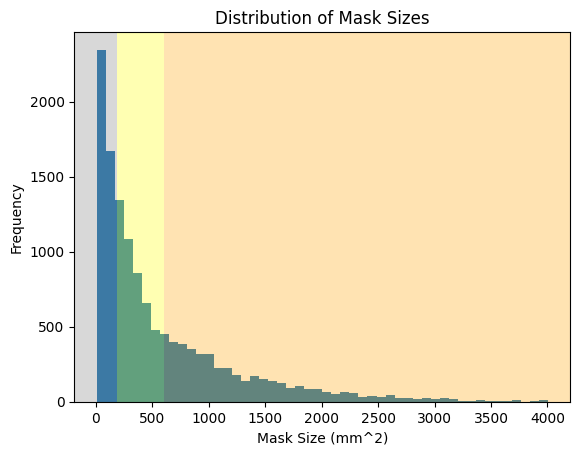

In [98]:

axes = plt.hist(mask_sizes, bins=50)
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
adiv = np.quantile(mask_sizes, [1/3,2/3])
print(adiv)

rect1 = patches.Rectangle((xmin, ymin), adiv[0]-xmin, ymax-ymin, linewidth=1, edgecolor='none', facecolor='grey', alpha=0.3)
rect2 = patches.Rectangle((adiv[0], ymin), adiv[1]-adiv[0], ymax-ymin, linewidth=1, edgecolor='none', facecolor='yellow', alpha=0.3)
rect3 = patches.Rectangle((adiv[1], ymin), xmax-adiv[1], ymax-ymin, linewidth=1, edgecolor='none', facecolor='orange', alpha=0.3)
# axes[0][0].add_patch(arrow1)
# fig, ax = plt.subplots()
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)
plt.gca().add_patch(rect3)

plt.xlabel('Mask Size (mm^2)')
plt.ylabel('Frequency')
plt.title('Distribution of Mask Sizes')
plt.show()

In [96]:
adiv

array([187., 605.])

In [43]:
# plot the performance vs size
import yaml
scores = {}
for nname in ['lg2unetr-fs24', 'unet1s','swinunetr-fs24','unetpp0','unetpp0D']:
    modelname = nname.split('-')[0]
    with open('/workspaces/data/MegaGen/logs/brats2-blMask/'+
            f'{nname}-e60/post-val0/{modelname}-test_maskA3_brats2-scores.yaml',
            'r') as f:
        scores[nname] = yaml.safe_load(f)
# scores


In [45]:
scores['swinunetr-fs24']

{'test': {'score_id_slice': 0.6865923485525374,
  'score_id_flat': 0.7234859151660271,
  'score_aslice': 0.7357233762741089},
 'valid': {'score_id_slice': 0.6906700074596672,
  'score_id_flat': 0.7347183981720282,
  'score_aslice': 0.754580557346344},
 'groups': [{'score_id_slice': 0.5803171992301941,
   'score_id_flat': 0.6289374232292175,
   'score_aslice': 0.5803171992301941},
  {'score_id_slice': 0.6974875032901764,
   'score_id_flat': 0.7317825555801392,
   'score_aslice': 0.8146578073501587},
  {'score_id_slice': 0.7467742562294006,
   'score_id_flat': 0.7827614744504293,
   'score_aslice': 0.8453477621078491}]}

In [44]:
# scores['unet1s']['groups']
#now print the patient-wise performance
for key,item in scores.items():
    print(key, f'환자당: {item["test"]["score_id_flat"]:.4f}',
          f'슬라이스 당: {item["test"]["score_aslice"]:.4f}')
    # print (key,item)


lg2unetr-fs24 환자당: 0.6793 슬라이스 당: 0.7112
unet1s 환자당: 0.7438 슬라이스 당: 0.7489
swinunetr-fs24 환자당: 0.7235 슬라이스 당: 0.7357
unetpp0 환자당: 0.7523 슬라이스 당: 0.7466
unetpp0D 환자당: 0.7695 슬라이스 당: 0.7606


In [ ]:
# import pandas as pd
# g_unet1s = pd.DataFrame([scores['unet1s']['groups'][i]['score_aslice'] for i in range(3)],    
#                          index=['S','M','L'])
# g_unet1s

In [ ]:
gscore_list = []
for nname in ['lg2unetr-fs24', 'unet1s','swinunetr-fs24','unetpp0','unetpp0D']:
    gscore_list.append([nname] + 
                       [scores[nname]['groups'][i]['score_aslice'] for i in range(3)] )
# g_unet1s = pd.DataFrame([ ['unet1s'] + [scores['unet1s']['groups'][i]['score_aslice'] for i in range(3)] ],    
#                          columns=['name','S','M','L'])
g_unet1s = pd.DataFrame(gscore_list,    
                         columns=['name','S','M','L'])
g_unet1s = g_unet1s.set_index('name')

In [36]:
g_unet1s

,S,M,L
name,,,
lg2unetr-fs24,0.537385,0.816755,0.821076
unet1s,0.626806,0.819205,0.828932
swinunetr-fs24,0.580317,0.814658,0.845348
unetpp0,0.624767,0.805223,0.834826
unetpp0D,0.628994,0.824358,0.855684


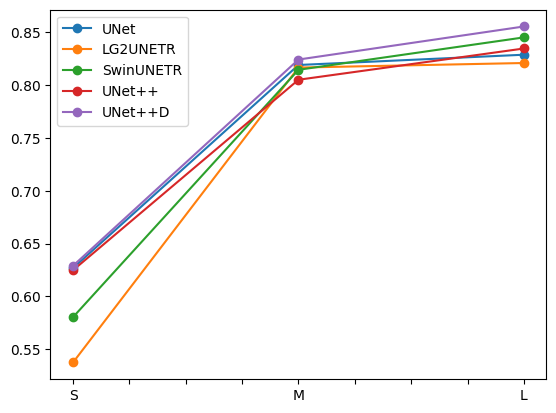

In [37]:
g_unet1s.loc["unet1s"].plot(marker='o',label="UNet")
g_unet1s.loc["lg2unetr-fs24"].plot(marker='o',label="LG2UNETR")
g_unet1s.loc["swinunetr-fs24"].plot(marker='o',label="SwinUNETR")
g_unet1s.loc["unetpp0"].plot(marker='o',label="UNet++")
g_unet1s.loc["unetpp0D"].plot(marker='o',label="UNet++D")
plt.legend()

In [ ]:
g_unet1s.to_csv('/workspaces/data/MegaGen/logs/SCORE/CSVS/score-sizes.csv')

In [43]:
import yaml
scoresL = []
for modelname in ['lg2unetr', 'unet1s','swinunetr','unetpp0','unetpp0D']:
    # modelname = nname.split('-')[0]
    for region in ['Frontal', 'Parietal', 'Temporal_L', 'Temporal_R']:
        with open(f'/workspaces/data/MegaGen/logs/SCORE/{modelname}/post-val1/'+
                f'{modelname}-out-test-ids-{region}-brats2-scores.yaml',
                'r') as f:
            scoreD = yaml.safe_load(f)
            scoresL.append([modelname, region, scoreD['test']['score_id_flat']])
scoresL = pd.DataFrame(scoresL, columns=['model','region','score_id_flat'])

In [45]:
scoresL.to_csv('/workspaces/data/MegaGen/logs/SCORE/CSVS/score-model-region.csv')

In [111]:
import yaml
scoresL = []
for modelname in ['lg2unetr', 'unet1s','swinunetr','unetpp0','unetpp0D']:
    # modelname = nname.split('-')[0]
    for vol in ['volume0', 'volume1', 'volume2']:
        with open(f'/workspaces/data/MegaGen/logs/SCORE/{modelname}/post-val1/'+
                f'{modelname}-out-test-ids-{vol}-brats2-scores.yaml',
                'r') as f:
            scoreD = yaml.safe_load(f)
            scoresL.append([modelname, vol, scoreD['test']['score_id_flat']])
scoresL = pd.DataFrame(scoresL, columns=['model','vol','score_id_flat'])
scoresL.to_csv('/workspaces/data/MegaGen/logs/SCORE/CSVS/score-model-volume.csv')

In [34]:
# threshold dependent performance
import yaml
scoresL = []
# for modelname in ['lg2unetr', 'unet1s','swinunetr','unetpp0','unetpp0D']:
for modelname in ['unetpp0D', 'unetpp0', 'unet1s', 'swinunetr', 'lg2unetr']:
    # modelname = nname.split('-')[0]
    for prob in ['10', '30', '50', '70', '90']:
        with open(f'/workspaces/data/MegaGen/logs/SCORE/{modelname}/post-prob1_{prob}/'+
                f'{modelname}-test-ids-brats2-scores.yaml',
                'r') as f:
            scoreD = yaml.safe_load(f)
            scoresL.append([modelname, prob, scoreD['test']['score_id_flat']])
scoresL = pd.DataFrame(scoresL, columns=['model','prob','score_id_flat'])
scoresL.to_csv('/workspaces/data/MegaGen/logs/SCORE/CSVS/score-model-threshold.csv')

,model,prob,score_id_flat
0,unetpp0D,10,0.767021
1,unetpp0D,30,0.767565
2,unetpp0D,50,0.767554
3,unetpp0D,70,0.767420
4,unetpp0D,90,0.767047
5,unetpp0,10,0.748915
6,unetpp0,30,0.749844
7,unetpp0,50,0.750096
8,unetpp0,70,0.750365
9,unetpp0,90,0.750358


In [17]:
import torch
aa = torch.load('/workspaces/data/brain_meningioma/oProb/unetpp0D/s_test/pt/BraTS-MEN-RT-0214-1_slice_055_mask.pt', 
                weights_only=False, map_location='cpu').numpy()

In [39]:
import yaml
scoresL = []
# for modelname in ['lg2unetr', 'unet1s','swinunetr','unetpp0','unetpp0D']:
for modelname in ['unetpp0D', 'unetpp0', 'unet1s', 'swinunetr', 'lg2unetr']:
    # modelname = nname.split('-')[0]
    with open(f'/workspaces/data/MegaGen/logs/SCORE/{modelname}/post-val1/'+
            f'{modelname}-test-ids-brats2-scores.yaml',
            'r') as f:
        scoreD = yaml.safe_load(f)
        scoresL.append([modelname, scoreD['test']['score_id_flat'], scoreD['test']['iou_id_flat']])
scoresL = pd.DataFrame(scoresL, columns=['model','dice_id_flat','iou_id_flat' ])
scoresL.to_csv('/workspaces/data/MegaGen/logs/SCORE/CSVS/score-model-ALL.csv')

In [38]:
scoresL

,model,dice_id_flat,iou_id_flat
0,unetpp0D,0.767554,0.654789
1,unetpp0,0.750096,0.636711
2,unet1s,0.740996,0.623840
3,swinunetr,0.719929,0.609803
4,lg2unetr,0.675003,0.561692


In [ ]:
import yaml
scoresL = []
for modelname in ['lg2unetr', 'unet1s','swinunetr','unetpp0','unetpp0D']:
    # modelname = nname.split('-')[0]
    for region in ["FrontalMNI",  "TemporalMNI", "ParietalMNI", "CerebellumMNI", "ThalamusMNI"]:
        with open(f'/workspaces/data/MegaGen/logs/SCORE/{modelname}/post-val1/'+
                f'{modelname}-out-test-ids-{region}-brats2-scores.yaml',
                'r') as f:
            scoreD = yaml.safe_load(f)
            if scoreD is None:
                print(modelname, region)
                continue
            scoresL.append([modelname, region, scoreD['test']['score_id_flat']]
                           )
scoresL

[['lg2unetr', 'FrontalMNI', 0.6750047480737841],
 ['lg2unetr', 'ParietalMNI', 0.7446765204270681],
 ['lg2unetr', 'TemporalMNI', 0.7778140703837076],
 ['lg2unetr', 'OccipitalMNI', 0.4286656081676483],
 ['lg2unetr', 'InsulaMNI', 0.8010028302669525],
 ['unet1s', 'FrontalMNI', 0.7380361669772381],
 ['unet1s', 'ParietalMNI', 0.7751920421918234],
 ['unet1s', 'TemporalMNI', 0.7843978305657705],
 ['unet1s', 'OccipitalMNI', 0.5641745030879974],
 ['unet1s', 'InsulaMNI', 0.7976180613040924],
 ['swinunetr', 'FrontalMNI', 0.7227047585152291],
 ['swinunetr', 'ParietalMNI', 0.7803020079930624],
 ['swinunetr', 'TemporalMNI', 0.7697315315405527],
 ['swinunetr', 'OccipitalMNI', 0.6213292926549911],
 ['swinunetr', 'InsulaMNI', 0.8573316931724548],
 ['unetpp0', 'FrontalMNI', 0.7476715783815127],
 ['unetpp0', 'ParietalMNI', 0.7374220987161001],
 ['unetpp0', 'TemporalMNI', 0.7903238932291666],
 ['unetpp0', 'OccipitalMNI', 0.6245190054178238],
 ['unetpp0', 'InsulaMNI', 0.8048053979873657],
 ['unetpp0D', 'Fro

In [75]:
# scoresL = pd.DataFrame(scoresL, columns=['model','region','score_id_flat','tv_id_flat'])
scoresL = pd.DataFrame(scoresL, columns=['model','region','score_id_flat'])
scoresL.to_csv('/workspaces/data/MegaGen/logs/SCORE/CSVS/score-model-region.csv')

In [66]:
os.path.join("/data/lijin/MegaGen/", "/MegaGen/aa")

'/MegaGen/aa'